In [1]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')  # hide warnings 

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import particles.mcmc as mcmc
import particles.state_space_models as ssm
import particles.distributions as dists
import seaborn

## Problem

The data are constituted of two independent counts of kangaroos population in New South Wales (Australia). Data are from Knape & De Valpine (2012). We aim to fit different population growth models on the historical data in order to predict the unobserved real population size from the countings.

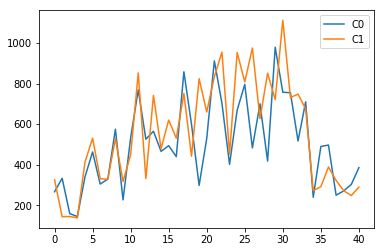

In [5]:
data = pd.read_csv("data.csv",index_col=0)
data.columns = ['C0','C1','time']
data[['C0','C1']].plot()

In [6]:
dt = data['time'].diff()
y = np.array(np.log(data[['C0', 'C1']]))
y_list=[]
for i in range(y.shape[0]):
    y_list.append(np.array([y[i]]))
    
mean_N0 = y[0].mean()
std_N0 = y[0].std()
print(mean_N0, std_N0)

5.687073019883479 0.09982436148322904


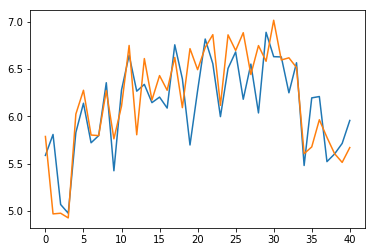

In [7]:
plt.plot(y)

## Definition of a Logistic Diffusion State-Space Model

The `LogisticDiffusion` state-space model is a model with the following dynamic for the unobserved variable:

$$ \frac{dy_t}{y_t} = (r+\frac{\sigma^2}{2}-b\times y_t)dt + \sigma dW_t$$

In our experiments we are just going to discretize this equation as follow:

$$ log(y_{t+1}) = log(y_t) + (r+\frac{\sigma^2}{2}-b\times y_t)\Delta_t + \sigma N(0, \Delta_t) $$

If we implement the model considering $z_t = log(y_t)$, we simply get:

$$ z_{t+1} \sim N(z_t + (r+\frac{\sigma^2}{2}-b\times exp(z_t))\Delta_t, \Delta_t )$$ 

This is the transition equation, for the emission equation we simply use a negative binomial distribution with mean $y_t$ and variance $y_t + \tau y_t^2$.

In Knape & De Valpine (2012), three models are considered:
* Model 1: parameters are r, b, $\sigma$
* Model 2: b=0, parameters are r and $\sigma$
* Model 3: r=b=0, the only parameter is $\sigma$

So actually the three models can be implemented using the same state space models class if we consider the above discretization as enough accurate for this experiment.

ToDO: Implement the model and correct priors with parameters r, b, sigma
The model can be implemented for log inputs to directly get normal distributions (and not lognormal): we have to think to log the inputs when we get the real data.

In [8]:
class LogisticDiffusion2D(ssm.StateSpaceModel):
    default_parameters={'r': 0., 'b': 0., 'sigma': 0.01, 'k':0.001, 'N0':np.log(200)}
    
    def PX0(self):
        return dists.Normal(loc=self.N0,scale=self.sigma)
    
    def PX(self, t, xp):
        loc = xp+(self.r-self.sigma**2/2+self.b*np.exp(xp))*dt[t]
        return dists.Normal(loc=loc,scale=self.sigma*np.sqrt(dt[t]))
    
    def PY(self, t, xp, x):
        return dists.IndepProd(dists.NegativeBinomial(n=1/self.k, p=1/(1+self.k*np.exp(x))),
                               dists.NegativeBinomial(n=1/self.k, p=1/(1+self.k*np.exp(x))))

### Some samples for the three state-space models

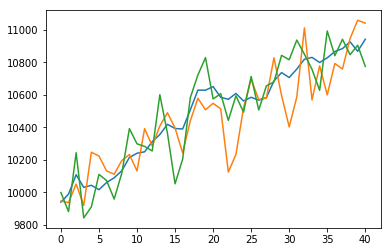

In [28]:
my_LD_ssm = LogisticDiffusion2D(r=0.005,b=1e-6,sigma=0.01,k=0.0001, N0=np.log(10000))

x0, y0 = my_LD_ssm.simulate(41)
y0 = np.asarray(y0)[:,0,:]
plt.plot(np.exp(x0))
plt.plot(y0)

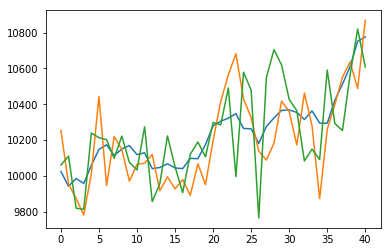

In [27]:
my_LD_ssm = LogisticDiffusion2D(r=0.005,b=0.,sigma=0.01,k=0.0001, N0=np.log(10000))

x1, y1 = my_LD_ssm.simulate(41)
y1 = np.asarray(y1)[:,0,:]
plt.plot(np.exp(x1))
plt.plot(y1)

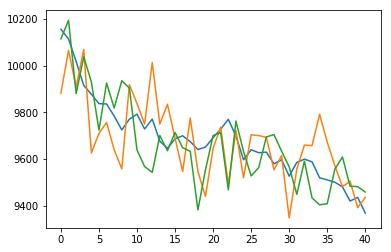

In [25]:
my_LD_ssm = LogisticDiffusion2D(r=0.,b=0.,sigma=0.01,k=0.0001, N0=np.log(10000))

x2, y2 = my_LD_ssm.simulate(41)
y2 = np.asarray(y2)[:,0,:]
plt.plot(np.exp(x2))
plt.plot(y2)

The author results show that the Random Walk model actually fits the data better. This is no surprise as plotting the counts seems to exhibit no particular drift.

## Basic PFMCMC models

We first try basic PFMCMC algorithms using the `particles` package implemented by Nicolas Chopin, from the most simple model to the most complicated one.

In [30]:
prior_dict_0 = {'k': dists.Uniform(a=0.,b=0.05),'N0':dists.Normal(loc=mean_N0,scale=std_N0),
             'sigma': dists.Uniform(a=0.,b=0.05), 'r': dists.Dirac(loc=0.),
             'b': dists.Dirac(loc=0.)}

prior_dict_2 = {'k': dists.Uniform(a=0.,b=0.15),'N0':dists.Normal(loc=mean_N0,scale=std_N0),
             'sigma': dists.Uniform(a=0.,b=2.), 'r': dists.Uniform(a=-2.,b=6.),
             'b': dists.Uniform(a=0., b=0.02)}


my_prior_0 = dists.StructDist(prior_dict_2)

my_pmmh_0 = mcmc.PMMH(ssm_cls=LogisticDiffusion2D, prior=my_prior_0, data=y_list, Nx=4000, niter=200, adaptive=True)
my_pmmh_0.run()

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 32.22it/s]


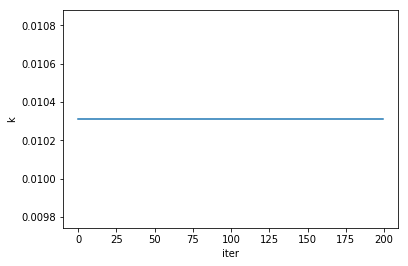

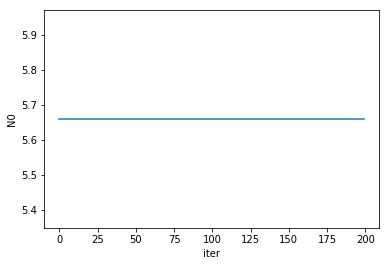

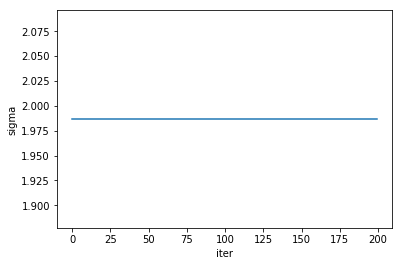

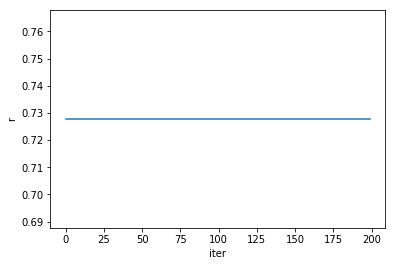

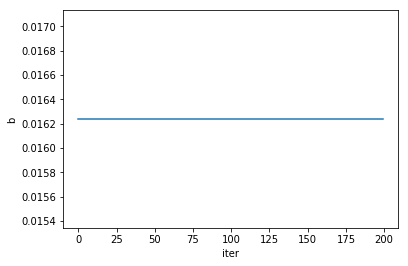

In [31]:
for p in prior_dict_0.keys():
    plt.figure()
    plt.plot(my_pmmh_0.chain.theta[p])
    plt.xlabel('iter')
    plt.ylabel(p)
plt.show()

In [32]:
my_pmmh_0.compute_post()
print('mean square jump distance: {}'.format(my_pmmh_0.mean_sq_jump_dist(discard_frac=0.1)))
print('posterior loglikelihood: {}'.format(my_pmmh_0.prop.lpost))
print('Acceptance rate: {}'.format(my_pmmh_0.acc_rate))

mean square jump distance: 0.0
posterior loglikelihood: [nan]
Acceptance rate: 0.0


The pmmh doesn't work, I print some values to try to understand why.

In [33]:
my_pmmh_0.prop.lpost

array([nan])

In [34]:
my_pmmh_0.prior.logpdf(my_pmmh_0.prop.theta)

array([4.38268146])

In [35]:
from particles import smc_samplers as ssp
pf = my_pmmh_0.alg_instance(ssp.rec_to_dict(my_pmmh_0.prop.theta[0]))
pf.run()
pf.logLt

nan

In [36]:
pf.__dict__

{'fk': <particles.state_space_models.Bootstrap at 0x1591df79a20>,
 'N': 4000,
 'seed': None,
 'qmc': False,
 'resampling': 'systematic',
 'ESSrmin': 0.5,
 'verbose': False,
 't': 41,
 'rs_flag': False,
 'logLt': nan,
 'wgts': <particles.resampling.Weights at 0x1591dfe9dd8>,
 'aux': <particles.resampling.Weights at 0x1591dfc4a58>,
 'X': array([inf, inf, inf, ..., inf, inf, inf]),
 'Xp': array([inf, inf, inf, ..., inf, inf, inf]),
 'A': array([   0,    1,    2, ..., 3997, 3998, 3999]),
 'summaries': None,
 'hist': None,
 'log_mean_w': nan,
 'loglt': nan,
 'cpu_time': 0.06551380454246925}

In [37]:
my_pmmh_0.__dict__

{'ssm_cls': __main__.LogisticDiffusion2D,
 'smc_cls': particles.core.SMC,
 'fk_cls': particles.state_space_models.Bootstrap,
 'prior': <particles.distributions.StructDist at 0x1591ddcef60>,
 'data': [array([[5.58724866, 5.78689738]]),
  array([[5.80814249, 4.9698133 ]]),
  array([[5.0689042 , 4.97673374]]),
  array([[4.97673374, 4.92725369]]),
  array([[5.82894562, 6.02344759]]),
  array([[6.13772705, 6.27476202]]),
  array([[5.72031178, 5.80211838]]),
  array([[5.79605775, 5.79605775]]),
  array([[6.35437004, 6.27098843]]),
  array([[5.42495002, 5.76205138]]),
  array([[6.27664349, 6.10702289]]),
  array([[6.64509097, 6.74758653]]),
  array([[6.26530121, 5.80513497]]),
  array([[6.33682573, 6.60934924]]),
  array([[6.14418563, 6.1717006 ]]),
  array([[6.20253552, 6.42971948]]),
  array([[6.08677473, 6.27476202]]),
  array([[6.7546041 , 6.62140565]]),
  array([[6.3952616 , 6.09130988]]),
  array([[5.69709349, 6.71417053]]),
  array([[6.27098843, 6.49223984]]),
  array([[6.81563999, 6.7

In [38]:
pf.generate_particles()

In [39]:
pf.X

array([ 2.64048831,  4.47414059, 11.62478993, ...,  7.37096242,
        4.25435052,  4.51293764])

## Tests with simpler models

In [40]:
class RandomWalk2D(ssm.StateSpaceModel):
    default_parameters={'sigma': 0.01, 'k':0.001, 'N0':np.log(200)}
    
    def PX0(self):
        return dists.Normal(loc=self.N0,scale=self.sigma)
    
    def PX(self, t, xp):
        return dists.Normal(loc=xp,scale=self.sigma*np.sqrt(dt[t]))
    
    def PY(self, t, xp, x):
        return dists.IndepProd(dists.NegativeBinomial(n=1/self.k, p=1/(1+self.k*np.exp(x))),
                               dists.NegativeBinomial(n=1/self.k, p=1/(1+self.k*np.exp(x))))

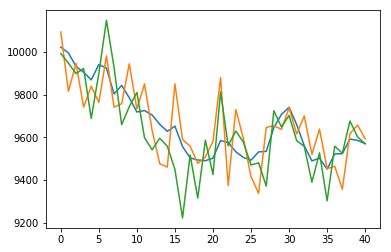

In [41]:
my_LD_ssm = RandomWalk2D(sigma=0.01,k=0.0001, N0=np.log(10000))

x2, y2 = my_LD_ssm.simulate(41)
y2 = np.asarray(y2)[:,0,:]
plt.plot(np.exp(x2))
plt.plot(y2)

In [43]:
prior_dict_RW = {'k': dists.Uniform(a=0.,b=10.),'N0':dists.Normal(loc=mean_N0,scale=std_N0),
             'sigma': dists.Uniform(a=0.,b=10.)}

p_RW = dists.StructDist(prior_dict_RW)

pmmh_RW= mcmc.PMMH(ssm_cls=RandomWalk2D, prior=p_RW, data=y_list, Nx=4000, niter=200, adaptive=True)
pmmh_RW.run()

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 26.18it/s]


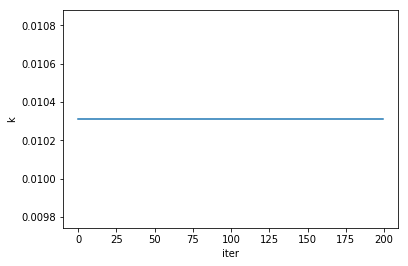

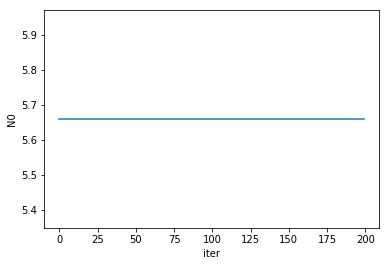

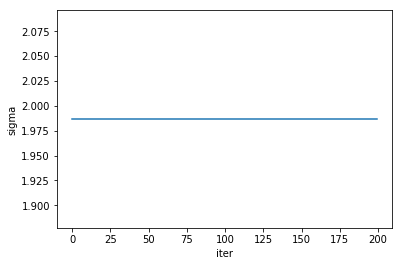

In [44]:
for p in prior_dict_RW.keys():
    plt.figure()
    plt.plot(my_pmmh_0.chain.theta[p])
    plt.xlabel('iter')
    plt.ylabel(p)
plt.show()

In [45]:
my_pmmh_0.compute_post()
print('mean square jump distance: {}'.format(my_pmmh_0.mean_sq_jump_dist(discard_frac=0.1)))
print('posterior loglikelihood: {}'.format(my_pmmh_0.prop.lpost))
print('Acceptance rate: {}'.format(my_pmmh_0.acc_rate))

mean square jump distance: 0.0
posterior loglikelihood: [nan]
Acceptance rate: 0.0


In [50]:
class RandomWalk2D_poisson(ssm.StateSpaceModel):
    default_parameters={'sigma': 0.01, 'N0':np.log(200)}
    
    def PX0(self):
        return dists.Normal(loc=self.N0,scale=self.sigma)
    
    def PX(self, t, xp):
        return dists.Normal(loc=xp,scale=self.sigma*np.sqrt(dt[t]))
    
    def PY(self, t, xp, x):
        return dists.IndepProd(dists.Poisson(rate=np.exp(x)),
                               dists.Poisson(rate=np.exp(x)))

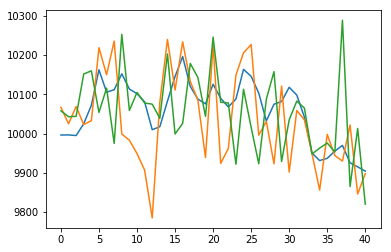

In [51]:
my_LD_ssm = RandomWalk2D_poisson(sigma=0.01, N0=np.log(10000))

x3, y3 = my_LD_ssm.simulate(41)
y3 = np.asarray(y3)[:,0,:]
plt.plot(np.exp(x3))
plt.plot(y3)

In [52]:
prior_dict_RWp = {'N0':dists.Normal(loc=mean_N0,scale=std_N0),
             'sigma': dists.Uniform(a=0.,b=10.)}

p_RWp = dists.StructDist(prior_dict_RW)

pmmh_RWp= mcmc.PMMH(ssm_cls=RandomWalk2D_poisson, prior=p_RW, data=y_list, Nx=4000, niter=200, adaptive=True)
pmmh_RWp.run()

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 32.46it/s]


In [53]:
my_pmmh_0.compute_post()
print('mean square jump distance: {}'.format(my_pmmh_0.mean_sq_jump_dist(discard_frac=0.1)))
print('posterior loglikelihood: {}'.format(my_pmmh_0.prop.lpost))
print('Acceptance rate: {}'.format(my_pmmh_0.acc_rate))

mean square jump distance: 0.0
posterior loglikelihood: [nan]
Acceptance rate: 0.0
